## Importing Libraries

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns # For data visualization
from sklearn.model_selection import GridSearchCV # For hyperparameter tuning
from sklearn.preprocessing import MinMaxScaler # For feature scaling, to maximise model performance
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

## Acquire data
#### Default risk
- Firm-specific factors: Profitability (ROA) + Leverage (Debt-to-Asset ratio) + Liquidity (Current ratio) + Firm Size + Cash flow + ESG + Industry Categories
- Macroeconomic factors: Interest rate 

In [500]:
# Set random seed for reproducibility (ensuring consistent results every run)
np.random.seed(42)
# Number of observations (companies)
n_samples = 100000

In [501]:
# Define industries
industries = ['Manufacturing & Construction','Distribution (Wholesale & Retail)','Food & Agriculture','Transportation','Services']
# Creating a DataFrame with random values simulating financial indicators
data = pd.DataFrame({
    'Debt_to_Asset Ratio': np.round(np.random.uniform(0, 1, n_samples), 4),         # Leverage
    'Current_Ratio': np.round(np.random.uniform(0.25, 3, n_samples), 4),            # Liquidity
    'ROA': np.round(np.random.uniform(-0.5, 0.3, n_samples), 4),                    # Profitability
    'Firm_Size': np.round(np.random.uniform(10, 20, n_samples), 4),                 # Log firm size
    'Cash_Flow': np.round(np.random.uniform(-0.5, 1.0, n_samples), 4),              # Cash flow to debt ratio
    'ESG': np.random.randint(1,10, n_samples),                                      # ESG score
    'Industry': np.random.choice(industries, size=n_samples)                        # Industry categorical variable
})

# Map industries to numeric codes (1–9)
industry_mapping = {industry: i+1 for i, industry in enumerate(industries)}
data['Industry_Code'] = data['Industry'].map(industry_mapping)
data = data.drop(columns=['Industry'])                                              #Drop the 'Industry' column as it's not needed for EDA

print(industry_mapping)
data

{'Manufacturing & Construction': 1, 'Distribution (Wholesale & Retail)': 2, 'Food & Agriculture': 3, 'Transportation': 4, 'Services': 5}


,Debt_to_Asset Ratio,Current_Ratio,ROA,Firm_Size,Cash_Flow,ESG,Industry_Code
0,0.3745,1.8471,-0.2739,11.5705,0.8334,1,4
1,0.9507,1.6992,-0.1331,10.9551,-0.0264,7,5
2,0.7320,1.2154,-0.4206,11.3794,-0.4221,6,5
3,0.5987,1.6063,-0.1425,14.7349,0.8796,7,3
4,0.1560,1.2540,-0.3375,18.8453,0.1544,8,2
...,...,...,...,...,...,...,...
99995,0.7923,1.9609,-0.4258,17.5015,0.4983,1,2
99996,0.7793,1.9804,0.0005,12.7253,0.9842,3,4
99997,0.6745,0.7786,0.0013,15.7559,0.2316,1,2
99998,0.4994,2.0460,-0.4619,18.9334,0.4975,9,4


In [521]:
# Set industry coefficients based on industry codes
industry_coefficient = np.where(data['Industry_Code'] == 1, -0.15,
    np.where(data['Industry_Code'] == 2, -0.1,
        np.where(data['Industry_Code'] == 3, -0.02,
            np.where(data['Industry_Code'] == 4, -0.04,
                np.where(data['Industry_Code'] == 5, -0.01, 0)
            )
        )
    )
)

In [522]:
prob_default = (
    +0.5 * data['Debt_to_Asset Ratio'] +            #Leverage
    -0.4 * data['ROA'] +                            #Profitability (ROA)
    -0.32 * data['Current_Ratio'] +                 #Liquidity
    -0.15 * data['Firm_Size'] +                     #
    -0.4 * data['Cash_Flow'] +
    +0.02 * data['ESG'] +                           #
    industry_coefficient * data['Industry_Code'] +  # Custom coefficients by industry
    np.random.normal(0, 0.1, n_samples)             # Adding random noise (mean=0, std=0.1)
)

# Convert continuous probabilities to binary classification:
# Companies with risk score above average are labeled as 'Default' (1), others as 'No Default' (0)
data['Default'] = (prob_default > prob_default.mean()).astype(int)

## Data Preparation

### Data Exploration (EDA)


Default Distribution:
Default
1    50035
0    49965
Name: count, dtype: int64

Default Percentage:
Default
1    50.035
0    49.965
Name: proportion, dtype: float64


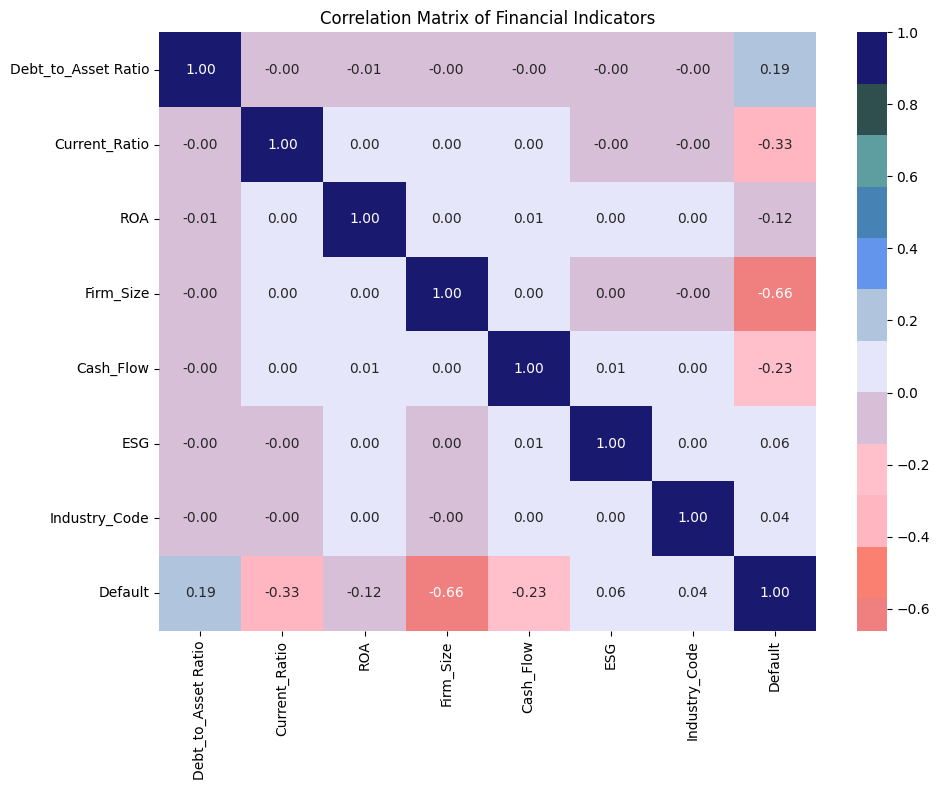

In [524]:
# Exploratory Data Analysis (EDA)
print("\nDefault Distribution:")
print(data['Default'].value_counts())
print("\nDefault Percentage:")
print(data['Default'].value_counts(normalize=True) * 100)

# Define your 12 CSS4 colors
css_colors = [
    "maroon", "palevioletred", "lightcoral", "salmon", "lightpink", "pink", "thistle","lavender", 
    "lightsteelblue", "cornflowerblue", "steelblue", "cadetblue", "darkslategray", "midnightblue"]
# Create a custom colormap
custom_cmap = ListedColormap(css_colors)

# Correlation Matrix
import seaborn as sns
plt.figure(figsize=(10, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap=custom_cmap, center=0, fmt='.2f')
plt.title('Correlation Matrix of Financial Indicators')
plt.tight_layout()
plt.show()

### Data Pre-Processing
- Data cleaning (generated dataset without missing values)
- Feature selection

In [525]:
# Features (X) and target variable (y)
x = data.drop(['Default'], axis=1)  # Independent variables (financial indicators)
y = data['Default']               # Dependent variable (default status)

# Splitting dataset into training (70%) and testing (20%) subsets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Data Analysis - ML Algorithm 

### Decision Tree

In [526]:
clf = DecisionTreeClassifier(max_depth=5, random_state=42) # Create a Decision Tree Classifier (max_depth=4 restricts tree complexity)
clf.fit(x_train, y_train) # Train the model on the training data
y_pred = clf.predict(x_test) # Predict default status using the trained model on test data
accuracy_clf = accuracy_score(y_test, y_pred) # Evaluate accuracy of the model
print(f'model accuracy: {accuracy_clf:.2f}\n')
print('report:') # Detailed classification metrics (precision, recall, F1-score)
print(classification_report(y_test, y_pred))

model accuracy: 0.88

report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88     10025
           1       0.87      0.88      0.88      9975

    accuracy                           0.88     20000
   macro avg       0.88      0.88      0.88     20000
weighted avg       0.88      0.88      0.88     20000



In [527]:
# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20, 50],
    'min_samples_leaf': [1, 2, 4, 10, 20],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': [None, 'sqrt', 'log2']
}

# Create base model
dt = DecisionTreeClassifier(random_state=42)

# Grid search with cross-validation
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,               # 5-fold cross-validation
    scoring='accuracy', # Optimizing for accuracy
    n_jobs=-1
)

# Fit on training data
grid_search.fit(x_train, y_train)

# Get the best model
best_dt = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Evaluate on test set
y_pred = best_dt.predict(x_test)
accuracy_clf = accuracy_score(y_test, y_pred)
print(f"Optimized Decision Tree Accuracy: {accuracy_clf:.2f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Best parameters: {'criterion': 'entropy', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
Optimized Decision Tree Accuracy: 0.91

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91     10025
           1       0.92      0.91      0.91      9975

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



### Other Models
- Logistic Regression
- Random Forest
- Support Vector Machine (SVM) - Support Vector Classifier (SVC)

In [528]:
#Logistic Regression Model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(x_train, y_train)
y_pred_log_reg = log_reg.predict(x_test)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f'Logistic Regression model accuracy: {accuracy_log_reg:.2f}\n')
print('Logistic Regression report:')
print(classification_report(y_test, y_pred_log_reg))

Logistic Regression model accuracy: 0.94

Logistic Regression report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     10025
           1       0.94      0.94      0.94      9975

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



In [529]:
# Random Forest Classifier
rf_clf = RandomForestClassifier(
    n_estimators=100,     # Number of trees in the forest
    max_depth=10,         # Maximum depth of trees
    random_state=42
)

rf_clf.fit(x_train, y_train)
y_pred_rf = rf_clf.predict(x_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf:.3f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.932

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     10025
           1       0.93      0.93      0.93      9975

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000



In [530]:
# Support Vector Classifier (SVC)

# Scale the features for SVC (SVC is sensitive to feature scale)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


svc_clf = SVC(
    kernel='rbf',         # Radial basis function kernel
    C=1.0,               # Regularization parameter
    gamma='scale',       # Kernel coefficient
    random_state=42
)
svc_clf.fit(x_train_scaled, y_train)
y_pred_svc = svc_clf.predict(x_test_scaled)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f'SVC Accuracy: {accuracy_svc:.3f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred_svc))

SVC Accuracy: 0.942

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     10025
           1       0.94      0.94      0.94      9975

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



### Model Comparison

MODEL COMPARISON SUMMARY
                 Model  Accuracy    Model_Type
0        Decision Tree     0.913    Tree-based
1  Logistic Regression     0.942    Regression
2        Random Forest     0.932      Ensemble
3                  SVC     0.942  Kernel-based


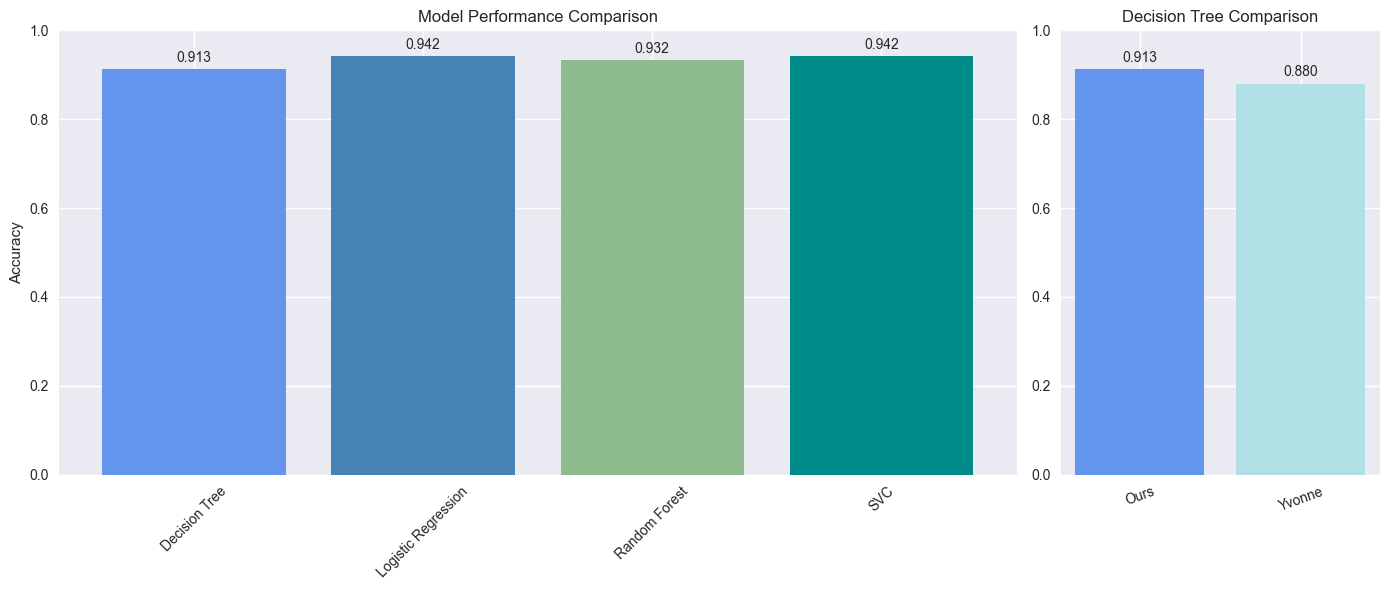

In [538]:
teacher_acc = 0.88

#Main comparison 
models_comparison = pd.DataFrame({
    'Model': ['Decision Tree', 'Logistic Regression', 'Random Forest', 'SVC'],
    'Accuracy': [accuracy_clf, accuracy_log_reg, accuracy_rf, accuracy_svc],
    'Model_Type': ['Tree-based', 'Regression', 'Ensemble', 'Kernel-based']
})

# Subplot dataframe (only decision tree comparison)
dt_comparison = pd.DataFrame({
    'Model': ['Ours', 'Yvonne'],
    'Accuracy': [accuracy_clf, teacher_acc]
})

# Model Comparison
print("MODEL COMPARISON SUMMARY")
print(models_comparison.round(3))

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [3, 1]})

# Main plot: all models
ax1.bar(models_comparison['Model'], models_comparison['Accuracy'],
        color=['cornflowerblue', 'steelblue', 'darkseagreen', 'darkcyan'])
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Performance Comparison')
ax1.set_ylim(0, 1)
for i, v in enumerate(models_comparison['Accuracy']):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
ax1.tick_params(axis='x', rotation=45)

# Subplot: your vs teacher DT
ax2.bar(dt_comparison['Model'], dt_comparison['Accuracy'],
        color=['cornflowerblue', 'powderblue'])
ax2.set_title('Decision Tree Comparison')
ax2.set_ylim(0, 1)
for i, v in enumerate(dt_comparison['Accuracy']):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
ax2.tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.show()

In [533]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# predict probabilities
pred_prob1 = clf.predict_proba(x_test)
pred_prob2 = log_reg.predict_proba(x_test)
pred_prob3 = rf_clf.predict_proba(x_test)
pred_prob4 = svc_clf.decision_function(x_test_scaled)

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_test, pred_prob4, pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])
auc_score3 = roc_auc_score(y_test, pred_prob3[:,1])
auc_score4 = roc_auc_score(y_test, pred_prob4)


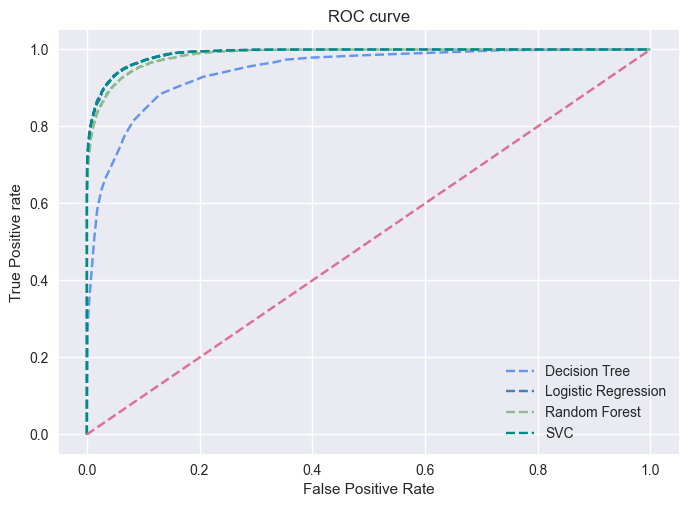

In [537]:
# visualize roc curves
plt.style.use('seaborn-v0_8')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='cornflowerblue', label='Decision Tree')
plt.plot(fpr2, tpr2, linestyle='--',color='steelblue', label='Logistic Regression')
plt.plot(fpr3, tpr3, linestyle='--',color='darkseagreen', label='Random Forest')
plt.plot(fpr4, tpr4, linestyle='--',color='darkcyan', label='SVC')
plt.plot(p_fpr, p_tpr, linestyle='--', color='palevioletred')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();